In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/SHA256SUMS.txt
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/CHANGELOG.txt
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/LICENSE.txt
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/icu/outputevents.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/icu/procedureevents.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/icu/datetimeevents.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/icu/ingredientevents.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/icu/chartevents.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/icu/inputevents.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/icu/icustays.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/icu/d_items.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/hosp/poe.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/hosp/d_labitems.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/hosp/drgcodes.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/hosp/d_icd_diagnoses.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/hosp/emar.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/hosp/omr.csv
/kaggle/in

In [33]:
# === Cell 1: imports & config ===
import os, math, random, gc
import numpy as np
import pandas as pd
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

BASE = "/kaggle/input/mimic-iv-2-1/mimic-iv-2.1"  # edit if needed

# Controls (safe for T4). Bump K_* or T_MAX if you have more VRAM/time.
T_MAX   = 8            # cap admissions per patient
K_DX    = 128          # top diagnosis codes
K_LAB   = 32           # top lab items
K_MED   = 64           # top medications (drug names)
K_PROC  = 64           # top procedure codes

BATCH   = 512
EPOCHS  = 200
LR      = 1e-3
BETA    = 1e-3         # KL weight
D_LAT   = 16           # latent dim (z)
D_MODEL = 128          # transformer width

pd.options.display.max_columns = 200


Device: cuda


In [21]:
# === Cell 1.5: data preprocessing utilities ===
import gc
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# ✅ 1. Check that MIMIC files exist
# -----------------------------
def check_mimic_files(base_path):
    required = [
        "hosp/admissions.csv",
        "hosp/diagnoses_icd.csv",
        "hosp/procedures_icd.csv",
        "hosp/labevents.csv",
        "hosp/prescriptions.csv",
        "icu/icustays.csv"
    ]
    missing = [f for f in required if not os.path.exists(os.path.join(base_path, f))]
    if missing:
        raise FileNotFoundError(f"Missing required MIMIC files: {missing}")
    else:
        print("✅ All essential MIMIC-IV files found under:", base_path)

check_mimic_files(BASE)

# -----------------------------
# ✅ 2. Memory optimization helpers
# -----------------------------
import pandas as pd
import numpy as np

def reduce_mem_usage(df, verbose=True):
    """Downcast numeric columns to save memory."""
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if pd.api.types.is_numeric_dtype(col_type):
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                else:
                    df[col] = df[col].astype(np.float32)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Memory ↓ {start_mem:.2f} → {end_mem:.2f} MB ({100*(1-end_mem/start_mem):.1f}% reduction)")
    return df

# -----------------------------
# ✅ 3. Chunked CSV reader (for big tables like labevents)
# -----------------------------
def read_chunked(path, nrows=None, usecols=None):
    """Reads large CSVs in chunks and concatenates them (optional nrows)."""
    chunks = []
    for chunk in pd.read_csv(path, chunksize=1_000_000, usecols=usecols, nrows=nrows):
        chunks.append(chunk)
        if nrows and sum(len(c) for c in chunks) >= nrows:
            break
    df = pd.concat(chunks, ignore_index=True)
    print(f"Loaded {len(df):,} rows from {os.path.basename(path)}")
    return df

# -----------------------------
# ✅ 4. Quick summary helper
# -----------------------------
def quick_summary(df, name):
    print(f"\n📘 {name} shape: {df.shape}")
    print(df.head(3))
    print(df.dtypes.head())
    print("-"*60)
    gc.collect()

print("Preprocessing utilities loaded successfully.")


✅ All essential MIMIC-IV files found under: /kaggle/input/mimic-iv-2-1/mimic-iv-2.1
Preprocessing utilities loaded successfully.


In [5]:
# === Cell 1.6: complete preprocessing pipeline for MIMIC-IV ===
import pandas as pd
import numpy as np

def clean_mimic_tables(adm, dx, labs, meds, procs, icu):
    """End-to-end cleaning for all core MIMIC tables."""
    print("🧹 Cleaning Admissions...")
    # --- Admissions ---
    adm = adm.drop_duplicates(subset=["hadm_id"])
    adm = adm.dropna(subset=["admittime", "dischtime"])
    adm = adm[adm["dischtime"] > adm["admittime"]]             # logical check
    adm["admittime"] = pd.to_datetime(adm["admittime"])
    adm["dischtime"] = pd.to_datetime(adm["dischtime"])
    adm["los_days"] = (adm["dischtime"] - adm["admittime"]).dt.total_seconds()/86400.0
    # clip extreme LOS (0–120 days typical)
    adm["los_days"] = adm["los_days"].clip(lower=0.01, upper=120)
    adm["hospital_expire_flag"] = adm["hospital_expire_flag"].astype("int8")
    adm = reduce_mem_usage(adm)

    print("🧹 Cleaning Diagnoses...")
    # --- Diagnoses ---
    dx["icd_code"] = dx["icd_code"].astype(str).str.strip()
    dx = dx.dropna(subset=["hadm_id", "icd_code"])
    dx = dx.drop_duplicates()
    dx = reduce_mem_usage(dx)

    print("🧹 Cleaning Lab events...")
    # --- Labs ---
    labs = labs.dropna(subset=["subject_id", "hadm_id", "valuenum"])
    labs = labs[labs["valuenum"].between(-1e4, 1e6)]            # filter absurd values
    labs = reduce_mem_usage(labs)

    print("🧹 Cleaning Medications...")
    # --- Medications ---
    meds["drug"] = meds["drug"].astype(str).str.lower().str.strip()
    meds = meds.dropna(subset=["subject_id", "hadm_id", "drug"])
    meds = meds.drop_duplicates(["subject_id", "hadm_id", "drug"])
    meds = reduce_mem_usage(meds)

    print("🧹 Cleaning Procedures...")
    # --- Procedures ---
    procs["icd_code"] = procs["icd_code"].astype(str).str.strip()
    procs = procs.dropna(subset=["hadm_id", "icd_code"])
    procs = procs.drop_duplicates(["subject_id", "hadm_id", "icd_code"])
    procs = reduce_mem_usage(procs)

    print("🧹 Cleaning ICU stays...")
    # --- ICU stays ---
    icu = icu.drop_duplicates(["subject_id", "hadm_id"])
    icu = reduce_mem_usage(icu)

    print("✅ All tables cleaned & memory optimized.")
    return adm, dx, labs, meds, procs, icu


def handle_outliers(df, numeric_cols, method="iqr"):
    """Generic numeric outlier trimming."""
    for c in numeric_cols:
        if c not in df.columns: continue
        q1, q3 = df[c].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
        df[c] = np.clip(df[c], lower, upper)
    return df


def normalize_features(df, cols):
    """Standardize numeric columns (z-score)."""
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    df[cols] = scaler.fit_transform(df[cols])
    print(f"🔧 Normalized {len(cols)} features.")
    return df


def final_precheck(df, name):
    print(f"\n📋 {name} checks:")
    print("Rows:", len(df))
    print("Missing values per column (top 5):")
    print(df.isna().sum().sort_values(ascending=False).head())
    print("Numeric summary:")
    print(df.describe().T.head())
    print("-"*70)

print("Full preprocessing functions ready ✅")


Full preprocessing functions ready ✅


In [39]:
# === Cell 2 (optimized): load needed MIMIC-IV tables ===
from collections import Counter

def read_top_values(path, col, top_n=500, chunksize=500_000):
    """Scan large CSV in chunks to find top-N frequent values in a column."""
    counter = Counter()
    for chunk in pd.read_csv(path, usecols=[col], chunksize=chunksize):
        counter.update(chunk[col].dropna())
    top_vals = [k for k, _ in counter.most_common(top_n)]
    print(f"Top {top_n} {col} values → {len(top_vals)} unique")
    return set(top_vals)

print("🔹 Loading core hospital tables...")
adm_cols = ["subject_id","hadm_id","admittime","dischtime","hospital_expire_flag"]
adm = pd.read_csv(f"{BASE}/hosp/admissions.csv", usecols=adm_cols, parse_dates=["admittime","dischtime"])
patients = pd.read_csv(f"{BASE}/hosp/patients.csv", usecols=["subject_id","gender","anchor_age","dod"], parse_dates=["dod"])

# --- Diagnoses / Procedures (already manageable size)
dx = pd.read_csv(f"{BASE}/hosp/diagnoses_icd.csv", usecols=["subject_id","hadm_id","icd_code","icd_version"])
procs = pd.read_csv(f"{BASE}/hosp/procedures_icd.csv", usecols=["subject_id","hadm_id","icd_code","icd_version"])

# --- ICU stays (small)
icustays = pd.read_csv(f"{BASE}/icu/icustays.csv", usecols=["subject_id","hadm_id"]).drop_duplicates()

# --- Labs: read only top-N lab itemids
print("🔹 Sampling top lab itemids...")
top_lab_ids = read_top_values(f"{BASE}/hosp/labevents.csv", "itemid", top_n=100)
labs_iter = pd.read_csv(f"{BASE}/hosp/labevents.csv",
                        usecols=["subject_id","hadm_id","itemid","valuenum"],
                        chunksize=500_000)
labs_chunks = [c[c["itemid"].isin(top_lab_ids)] for c in labs_iter]
labs = pd.concat(labs_chunks, ignore_index=True)
del labs_chunks; gc.collect()

# --- Medications: read only top-N drugs
print("🔹 Sampling top medications...")
top_drugs = read_top_values(f"{BASE}/hosp/prescriptions.csv", "drug", top_n=200)
meds_iter = pd.read_csv(f"{BASE}/hosp/prescriptions.csv",
                        usecols=["subject_id","hadm_id","drug"],
                        chunksize=500_000)
meds_chunks = [c[c["drug"].isin(top_drugs)] for c in meds_iter]
meds = pd.concat(meds_chunks, ignore_index=True)
del meds_chunks; gc.collect()

# --- Basic LOS cleaning
adm = adm.dropna(subset=["admittime","dischtime"]).copy()
adm["los_days"] = (adm["dischtime"] - adm["admittime"]).dt.total_seconds()/86400.0
adm["los_days"] = adm["los_days"].clip(lower=0.01, upper=60)

# Apply log1p normalization to stabilize LOS distribution
adm["los_days_log"] = np.log1p(adm["los_days"])

print(f"✅ Loaded shapes → adm {adm.shape} | dx {dx.shape} | labs {labs.shape} | "
      f"meds {meds.shape} | procs {procs.shape} | icustays {icustays.shape}")


🔹 Loading core hospital tables...
🔹 Sampling top lab itemids...
Top 100 itemid values → 100 unique
🔹 Sampling top medications...
Top 200 drug values → 200 unique
✅ Loaded shapes → adm (431088, 7) | dx (4752265, 4) | labs (108524928, 4) | meds (13336682, 3) | procs (668993, 4) | icustays (66189, 2)


In [8]:
# === Cell 3: per-admission features by modality ===

# --- Diagnoses: pick top-K codes (ICD9/10 together by raw code string) ---
dx["icd_code"] = dx["icd_code"].astype(str)
top_dx = dx["icd_code"].value_counts().index[:K_DX].tolist()
dx_k = dx[dx["icd_code"].isin(top_dx)]
dx_feat = (dx_k.groupby(["subject_id","hadm_id","icd_code"]).size().rename("cnt").reset_index())
dx_piv = dx_feat.pivot_table(index=["subject_id","hadm_id"], columns="icd_code", values="cnt", fill_value=0).reset_index()
for c in top_dx:
    if c not in dx_piv.columns: dx_piv[c] = 0
dx_piv = dx_piv[["subject_id","hadm_id"] + top_dx]

# --- Labs: pick top-K lab items; summarize per admission (mean, std, count) → here: mean only for simplicity ---
labs = labs.dropna(subset=["valuenum"])
top_lab = labs["itemid"].value_counts().index[:K_LAB].tolist()
labs_k = labs[labs["itemid"].isin(top_lab)]
lab_agg = labs_k.groupby(["subject_id","hadm_id","itemid"])["valuenum"].mean().rename("val").reset_index()
lab_piv = lab_agg.pivot_table(index=["subject_id","hadm_id"], columns="itemid", values="val", fill_value=np.nan).reset_index()
lab_cols = [f"lab_{i}" for i in top_lab]
lab_piv.columns = ["subject_id","hadm_id"] + lab_cols

# --- Meds: top-K drug names; per-admission counts ---
meds["drug"] = meds["drug"].astype(str).str.lower().str.strip()
top_med = meds["drug"].value_counts().index[:K_MED].tolist()
meds_k = meds[meds["drug"].isin(top_med)]
med_feat = meds_k.groupby(["subject_id","hadm_id","drug"]).size().rename("cnt").reset_index()
med_piv = med_feat.pivot_table(index=["subject_id","hadm_id"], columns="drug", values="cnt", fill_value=0).reset_index()
med_cols = [f"med_{m}" for m in med_piv.columns[2:]]
# rename to consistent prefix
ren = dict(zip(list(med_piv.columns[2:]), med_cols))
med_piv = med_piv.rename(columns=ren)

# --- Procedures: top-K; per-admission counts ---
procs["icd_code"] = procs["icd_code"].astype(str)
top_proc = procs["icd_code"].value_counts().index[:K_PROC].tolist()
proc_k = procs[procs["icd_code"].isin(top_proc)]
proc_feat = proc_k.groupby(["subject_id","hadm_id","icd_code"]).size().rename("cnt").reset_index()
proc_piv = proc_feat.pivot_table(index=["subject_id","hadm_id"], columns="icd_code", values="cnt", fill_value=0).reset_index()
proc_cols = [f"proc_{c}" for c in proc_piv.columns[2:]]
renp = dict(zip(list(proc_piv.columns[2:]), proc_cols))
proc_piv = proc_piv.rename(columns=renp)

# --- Merge all modality features with admissions ---
core = adm.merge(dx_piv, on=["subject_id","hadm_id"], how="left")
core = core.merge(lab_piv, on=["subject_id","hadm_id"], how="left")
core = core.merge(med_piv, on=["subject_id","hadm_id"], how="left")
core = core.merge(proc_piv, on=["subject_id","hadm_id"], how="left")

# Fill numeric missing (labs) with per-column median later (scaler will see NaNs otherwise)
mod_cols = top_dx + lab_cols + med_cols + proc_cols
for c in mod_cols:
    if c not in core.columns: core[c] = 0.0

# ICU resource label: whether admission had any ICU stay
icu_flag = icustays.assign(in_icu=1).drop_duplicates(["subject_id","hadm_id"])
core = core.merge(icu_flag, on=["subject_id","hadm_id"], how="left")
core["in_icu"] = core["in_icu"].fillna(0).astype(int)

print("Core shape:", core.shape, "Feature dim (raw):", len(mod_cols))
core.head(3)


Core shape: (431088, 295) Feature dim (raw): 288


,subject_id,hadm_id,admittime,dischtime,hospital_expire_flag,los_days,4019,2724,I10,E785,53081,25000,Z87891,42731,4280,311,41401,K219,V1582,F329,5849,2449,I2510,3051,2859,40390,F419,V5861,30000,N179,5990,2720,49390,V5867,Z794,5859,E039,Z7901,32723,E119,V4582,Y929,F17210,412,V5866,496,G4733,27800,E669,D649,I4891,Z7902,J45909,V4581,2761,41400,73300,30500,J449,33829,V1251,Z66,486,N390,2749,27651,D62,I129,V4986,V1254,V270,E1122,78650,I252,2851,N189,60000,56400,2762,5856,E871,Z8673,42789,3572,Z955,G8929,2875,V6284,78659,E872,I110,Z86718,40391,42832,78791,V103,I480,71590,N400,E8497,...,med_influenza vaccine quadrivalent,med_influenza virus vaccine,med_insulin,med_iso-osmotic dextrose,med_lactated ringers,med_levothyroxine sodium,med_lisinopril,med_lorazepam,med_magnesium sulfate,med_metoprolol succinate xl,med_metoprolol tartrate,med_milk of magnesia,med_morphine sulfate,med_multivitamins,med_neutra-phos,med_ns,med_omeprazole,med_ondansetron,med_oxycodone (immediate release),med_pantoprazole,med_polyethylene glycol,med_potassium chloride,med_potassium chloride replacement (critical care and oncology),med_prednisone,med_propofol,med_senna,med_sodium chloride 0.9%,med_sodium chloride 0.9% flush,med_sterile water,med_sw,med_trazodone,med_vancomycin,med_vial,med_vitamin d,med_warfarin,proc_0040,proc_0045,proc_0066,proc_009U3ZX,proc_02100Z9,proc_02H633Z,proc_02HV33Z,proc_0331,proc_0BH17EZ,proc_0DJ08ZZ,proc_0W9G3ZZ,proc_10E0XZZ,proc_3324,proc_3404,proc_3491,proc_3607,proc_3615,proc_3722,proc_3723,proc_3891,proc_3893,proc_3895,proc_3897,proc_3899,proc_3950,proc_3961,proc_3995,proc_3E04305,proc_3E0G76Z,proc_4513,proc_4516,proc_5185,proc_5187,proc_5459,proc_5491,proc_5A1221Z,proc_5A1945Z,proc_5A1955Z,proc_5A1D70Z,proc_7309,proc_734,proc_7359,proc_741,proc_7569,proc_8051,proc_8162,proc_8604,proc_8744,proc_8841,proc_8842,proc_8848,proc_8856,proc_8872,proc_8938,proc_8952,proc_9427,proc_9604,proc_966,proc_9671,proc_9672,proc_9904,proc_9915,proc_9925,proc_B211YZZ,in_icu
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,0,0.786111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,0,1.015278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,0,1.754167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [15]:
# === Cell 3.5: Filter MIMIC-IV cohort using Orphanet rare disease ICD codes ===
orph = pd.read_csv("/kaggle/input/rare-diseases/icd10_diseases.csv")  # or your uploaded path
orph["ICDcodes"] = orph["ICDcodes"].astype(str).str.strip()
rare_icd = set(orph["ICDcodes"].unique())

print(f"Loaded {len(rare_icd)} ICD codes from Orphanet mapping.")

# Filter MIMIC diagnoses table to only those rare ICDs
rare_dx = dx[dx["icd_code"].isin(rare_icd)]
rare_hadm_ids = rare_dx["hadm_id"].unique()
rare_subjects = rare_dx["subject_id"].unique()

print(f"Rare disease cohort → {len(rare_subjects)} patients | {len(rare_hadm_ids)} admissions")

# Subset the core table (already merged features)
core = core[core["hadm_id"].isin(rare_hadm_ids)].reset_index(drop=True)
print(f"Filtered core shape: {core.shape}")


Loaded 26 ICD codes from Orphanet mapping.
Rare disease cohort → 3781 patients | 5923 admissions
Filtered core shape: (5923, 295)


In [40]:
# === Optimized Cell 4: per-patient sequences, padding, scaling, targets ===
import numpy as np
from sklearn.preprocessing import StandardScaler
import gc

print("⏳ Building sequences per patient...")

core = core.sort_values(["subject_id", "admittime"]).reset_index(drop=True)

# --- median-impute numeric lab features ---
for c in lab_cols:
    medv = core[c].median(skipna=True)
    core[c].fillna(medv, inplace=True)
core[mod_cols] = core[mod_cols].fillna(0.0)

# --- compute feature mean/std incrementally (streaming) ---
scaler = StandardScaler(copy=False, with_mean=True, with_std=True)
scaler.partial_fit(core[mod_cols].to_numpy(dtype=np.float32))

# --- basic stats for shape ---
max_T = core.groupby("subject_id").size().max()
T_cap = min(T_MAX, max_T)
subjects = core["subject_id"].unique()
N = len(subjects)
D = len(mod_cols)

print(f"Patients: {N} | Max admissions: {max_T} | Feature dim: {D}")

# --- preallocate arrays once ---
X = np.zeros((N, T_cap, D), dtype=np.float32)
M = np.zeros((N, T_cap), dtype=np.float32)
Y_ICU = np.zeros(N, dtype=np.float32)
Y_LOS = np.zeros(N, dtype=np.float32)

# --- fill arrays sequentially without Python dict overhead ---
grp = core.groupby("subject_id", sort=False)
for i, (sid, g) in enumerate(grp):
    Xi = g[mod_cols].to_numpy(dtype=np.float32)
    L = min(Xi.shape[0], T_cap)
    X[i, :L, :] = Xi[:L]
    M[i, :L] = 1.0
    Y_ICU[i] = g["in_icu"].max()
    # --- log-normalize LOS to stabilize variance ---
    Y_LOS[i] = np.log1p(g["los_days"].sum())

    if i % 1000 == 0:
        print(f"→ processed {i}/{N} patients", end="\r")
        gc.collect()

print("\n✅ Raw sequences built. Now scaling...")

# --- scale in-place to avoid extra copies ---
flat = X.reshape(-1, D)
flat[:] = scaler.transform(flat)
X = flat.reshape(N, T_cap, D)

print(f"Final tensors → X {X.shape}, M {M.shape}, "
      f"ICU mean: {Y_ICU.mean():.3f}, LOS mean: {Y_LOS.mean():.2f}")
gc.collect()


⏳ Building sequences per patient...
Patients: 3781 | Max admissions: 25 | Feature dim: 288
→ processed 3000/3781 patients
✅ Raw sequences built. Now scaling...
Final tensors → X (3781, 8, 288), M (3781, 8), ICU mean: 0.321, LOS mean: 1.95


0

In [41]:
# === Cell 5: split + dataloaders ===
idx = np.arange(N)
rng = np.random.default_rng(SEED)
rng.shuffle(idx)
split = int(0.8 * N)
tr_idx, va_idx = idx[:split], idx[split:]

def _sub(a, ids): return a[ids]

X_tr, M_tr, yicu_tr, ylos_tr = _sub(X,tr_idx), _sub(M,tr_idx), _sub(Y_ICU,tr_idx), _sub(Y_LOS,tr_idx)
X_va, M_va, yicu_va, ylos_va = _sub(X,va_idx), _sub(M,va_idx), _sub(Y_ICU,va_idx), _sub(Y_LOS,va_idx)

class MultiModalSet(Dataset):
    def __init__(self, X, M, y_icu, y_los):
        self.X = torch.from_numpy(X); self.M = torch.from_numpy(M)
        self.y_icu = torch.from_numpy(y_icu).float()
        self.y_los = torch.from_numpy(y_los).float()
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        return self.X[i], self.M[i], self.y_icu[i], self.y_los[i]

num_workers = 2 if torch.cuda.is_available() else 0
train_ds = MultiModalSet(X_tr, M_tr, yicu_tr, ylos_tr)
val_ds   = MultiModalSet(X_va, M_va, yicu_va, ylos_va)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=num_workers, pin_memory=True, persistent_workers=(num_workers>0))
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=(num_workers>0))

xb, mb, ybi, ybl = next(iter(train_loader))
print("Batch shapes:", tuple(xb.shape), tuple(mb.shape))


Batch shapes: (512, 8, 288) (512, 8)


In [42]:
# === Cell 6: model ===
class AttentionPool(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.q = nn.Parameter(torch.randn(d))
    def forward(self, H, mask):
        # H: (B,T,d), mask: (B,T) 1=valid
        scores = (H * self.q).sum(-1)
        scores = scores.masked_fill(mask==0, -1e9)
        w = torch.softmax(scores, dim=-1).unsqueeze(-1)  # (B,T,1)
        z = (w * H).sum(1)                               # (B,d)
        return z, w.squeeze(-1)

class ModalityProjector(nn.Module):
    def __init__(self, d_in, d_model):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(d_in, d_model), nn.ReLU())
    def forward(self, x):  # (B,T,Di)
        return self.net(x)

class MultiModalVAE(pl.LightningModule):
    def __init__(self, dims, d_model=128, d_lat=16, lr=1e-3, beta=1e-3, recon_w=1.0,
                 icu_w=1.0, los_w=1.0, dropout=0.1, nhead=4, nlayers=2):
        """
        dims: dict with modality input dims:
              {"dx": K_DX, "lab": K_LAB, "med": K_MED, "proc": K_PROC}
        """
        super().__init__()
        self.save_hyperparameters()
        self.lr, self.beta = lr, beta
        self.recon_w, self.icu_w, self.los_w = recon_w, icu_w, los_w

        # modality projectors (split the fused vector back into blocks)
        self.slices = {}
        start = 0
        for k, d in dims.items():
            self.slices[k] = (start, start+d)
            start += d
        self.D_total = start

        self.proj_dx   = ModalityProjector(dims["dx"],  d_model//2)
        self.proj_lab  = ModalityProjector(dims["lab"], d_model//4)
        self.proj_med  = ModalityProjector(dims["med"], d_model//4)
        self.proj_proc = ModalityProjector(dims["proc"], d_model//4)
        fused_dim = d_model//2 + d_model//4 + d_model//4 + d_model//4  # concat

        enc_layer = nn.TransformerEncoderLayer(d_model=fused_dim, nhead=nhead,
                                               dim_feedforward=fused_dim*2, dropout=dropout,
                                               batch_first=True)
        self.tr = nn.TransformerEncoder(enc_layer, num_layers=nlayers)
        self.pool = AttentionPool(fused_dim)
        self.mu = nn.Linear(fused_dim, d_lat)
        self.logvar = nn.Linear(fused_dim, d_lat)

        # Decoder reconstructs average per-patient fused vector (not full sequence)
        self.dec = nn.Sequential(
            nn.Linear(d_lat, fused_dim), nn.ReLU(),
            nn.Linear(fused_dim, self.D_total)
        )

        # Resource heads (patient-level)
        self.h_icu = nn.Linear(d_lat, 1)     # ICU logit
        self.h_los = nn.Linear(d_lat, 1)     # LOS regression

    def _split_modalities(self, x):  # x:(B,T,D_total) → dict of (B,T,Di)
        outs = {}
        for k,(a,b) in self.slices.items():
            outs[k] = x[..., a:b]
        return outs

    def encode(self, x, m):
        # x: (B,T,D_total)
        md = self._split_modalities(x)
        h = [ self.proj_dx(md["dx"]),
              self.proj_lab(md["lab"]),
              self.proj_med(md["med"]),
              self.proj_proc(md["proc"]) ]
        H = torch.cat(h, dim=-1)  # (B,T,fused_dim)

        key_padding_mask = (m == 0)  # True where pad
        Ht = self.tr(H, src_key_padding_mask=key_padding_mask)
        zctx, att = self.pool(Ht, m)
        mu = self.mu(zctx); logvar = self.logvar(zctx)
        std = torch.exp(0.5*logvar); eps = torch.randn_like(std)
        z = mu + eps * std
        return z, mu, logvar, zctx, att

    def forward(self, x, m):
        z, mu, logvar, ctx, att = self.encode(x, m)
        recon = self.dec(z)                         # (B, D_total)
        icu_logit = self.h_icu(z).squeeze(-1)       # (B,)
        los_pred  = self.h_los(z).squeeze(-1)       # (B,)
        return recon, mu, logvar, z, icu_logit, los_pred, att

    def step(self, batch, stage):
        x, m, y_icu, y_los = batch
        x = x.float(); m = m.float()
        recon, mu, logvar, z, icu_logit, los_pred, att = self(x, m)

        # Build patient-level "target to reconstruct": mean over valid timesteps of raw features
        mask = m.unsqueeze(-1)  # (B,T,1)
        x_mean = (x * mask).sum(1) / (mask.sum(1)+1e-6)  # (B, D_total)
        rec = F.mse_loss(recon, x_mean)

        # KL
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        # Resource losses
        bce = F.binary_cross_entropy_with_logits(icu_logit, y_icu)
        mse = F.mse_loss(los_pred, y_los)

        loss = self.recon_w*rec + self.beta*kl + self.icu_w*bce + self.los_w*mse
        self.log_dict({f"{stage}_loss":loss, f"{stage}_rec":rec, f"{stage}_kl":kl,
                       f"{stage}_bce":bce, f"{stage}_mse":mse},
                      prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def training_step(self, batch, batch_idx): return self.step(batch, "train")
    def validation_step(self, batch, batch_idx): self.step(batch, "val")
    def configure_optimizers(self): return torch.optim.Adam(self.parameters(), lr=self.lr)

# Instantiate
dims = {"dx":K_DX, "lab":K_LAB, "med":K_MED, "proc":K_PROC}
model = MultiModalVAE(dims, d_model=D_MODEL, d_lat=D_LAT, lr=LR, beta=BETA)
print(model.__class__.__name__, "params:", sum(p.numel() for p in model.parameters())//1000, "K")


MultiModalVAE params: 481 K


In [43]:
# === Cell 7: train ===
from pytorch_lightning.loggers import CSVLogger

csv_logger = CSVLogger(save_dir="/kaggle/working", name="mm_vadesc_resource")
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    precision="16-mixed" if torch.cuda.is_available() else "32-true",
    log_every_n_steps=20,
    gradient_clip_val=1.0,
    logger=csv_logger
)
trainer.fit(model, train_loader, val_loader)
print("Logs at:", csv_logger.log_dir)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Logs at: /kaggle/working/mm_vadesc_resource/version_3


In [44]:
# === Cell 8 (GMM): cluster latent embeddings and summarize resources ===
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import torch

model.eval()
Z_list, ICU_list, LOS_list = [], [], []

# Use BOTH train and val sets to get latents for all patients
all_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset([train_ds, val_ds]),
    batch_size=BATCH, shuffle=False, num_workers=0
)

with torch.no_grad():
    for xb, mb, yicu, ylos in all_loader:
        _, mu, _, _, _, _, _ = model(xb.float(), mb.float())
        Z_list.append(mu.cpu().numpy())
        ICU_list.append(yicu.cpu().numpy())
        LOS_list.append(ylos.cpu().numpy())

Z   = np.concatenate(Z_list, 0)
ICU = np.concatenate(ICU_list, 0).astype(float)
LOS = np.concatenate(LOS_list, 0).astype(float)

# Search number of components by BIC
Ks = range(2, 7)
gmms, bics = [], []
for k in Ks:
    gmm = GaussianMixture(n_components=k, covariance_type="full",
                          reg_covar=1e-4, random_state=SEED)
    gmm.fit(Z)
    gmms.append(gmm); bics.append(gmm.bic(Z))

best_idx = int(np.argmin(bics))
bestK = Ks[best_idx]
gmm = gmms[best_idx]
labels = gmm.predict(Z)
proba  = gmm.predict_proba(Z)  # soft memberships

# Summaries (hard labels for readability; soft summaries also provided)
summary_hard = (pd.DataFrame({"cluster":labels, "icu":ICU, "los":LOS})
                .groupby("cluster")
                .agg(n=("icu","size"),
                     icu_rate=("icu","mean"),
                     mean_los=("los","mean"),
                     median_los=("los","median"))
                .reset_index()
                .sort_values("icu_rate", ascending=False))

# Soft (probability-weighted) summaries
rows = []
for k in range(bestK):
    w = proba[:, k]
    w_sum = w.sum() + 1e-8
    n_eff = w_sum
    icu_rate = (w * ICU).sum() / w_sum
    mean_los = (w * LOS).sum() / w_sum
    rows.append({"cluster": k, "n_eff": n_eff, "icu_rate_w": icu_rate, "mean_los_w": mean_los})
summary_soft = pd.DataFrame(rows).sort_values("icu_rate_w", ascending=False)

# Silhouette (uses hard labels; higher is better, ~0.2–0.5 is decent for health data)
sil = silhouette_score(Z, labels) if bestK > 1 else np.nan

print(f"Best K by BIC: {bestK} | BICs: {list(zip(Ks, np.round(bics,1)))}")
print(f"Silhouette (hard labels): {sil:.3f}\n")
print("Hard-label cluster summary:")
display(summary_hard)
print("\nSoft (probability-weighted) summary:")
display(summary_soft)

# Save for downstream analysis
np.save("/kaggle/working/latents.npy", Z)
np.save("/kaggle/working/cluster_labels.npy", labels)
np.save("/kaggle/working/cluster_proba.npy", proba)
summary_hard.to_csv("/kaggle/working/cluster_summary_hard.csv", index=False)
summary_soft.to_csv("/kaggle/working/cluster_summary_soft.csv", index=False)


Best K by BIC: 6 | BICs: [(2, 210742.8), (3, 208209.2), (4, 207702.8), (5, 206022.5), (6, 205753.5)]
Silhouette (hard labels): 0.001

Hard-label cluster summary:


,cluster,n,icu_rate,mean_los,median_los
4,4,628,0.964968,2.493354,2.404564
1,1,624,0.927885,2.613672,2.761525
0,0,678,0.020649,2.093306,2.072517
5,5,913,0.012048,1.601537,1.565283
3,3,358,0.008380,0.791844,0.758499
2,2,580,0.003448,1.743632,1.636296



Soft (probability-weighted) summary:


,cluster,n_eff,icu_rate_w,mean_los_w
4,4,620.752880,0.961111,2.498961
1,1,637.613068,0.924630,2.605075
0,0,699.574106,0.019669,2.079294
5,5,910.807602,0.010541,1.596273
3,3,353.261341,0.008372,0.792415
2,2,558.991003,0.004496,1.739374


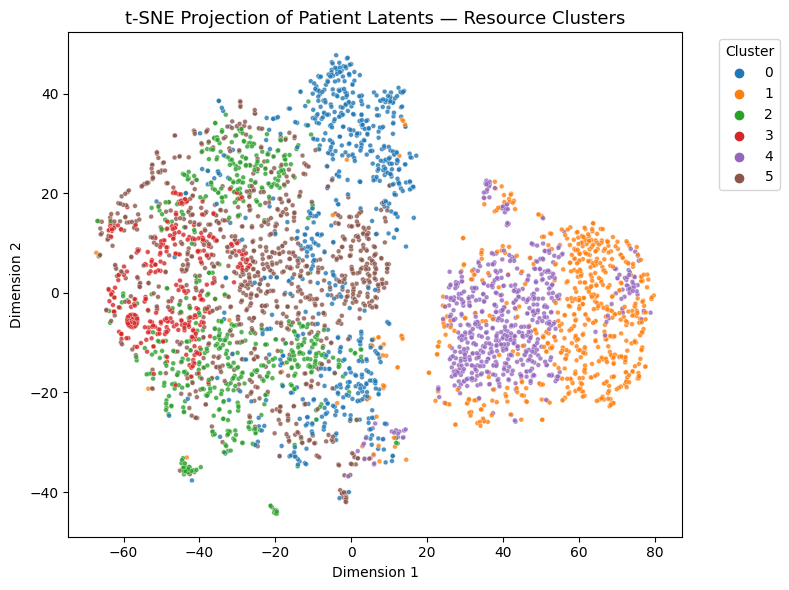

In [45]:
# === Cell 9A (robust visualization, works in all Kaggle runtimes) ===
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load saved latent vectors and cluster labels
Z = np.load("/kaggle/working/latents.npy").astype(np.float32)
labels = np.load("/kaggle/working/cluster_labels.npy")

# Step 1 — reduce noise with PCA (VaDeSC-EHR latent is high-dimensional)
Z_pca = PCA(n_components=min(30, Z.shape[1]), random_state=42).fit_transform(Z)

# Step 2 — map to 2D using t-SNE for nonlinear separation
tsne = TSNE(
    n_components=2, 
    perplexity=30, 
    learning_rate="auto", 
    init="pca", 
    random_state=42
)
Z_2d = tsne.fit_transform(Z_pca)

# Step 3 — plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=Z_2d[:,0], 
    y=Z_2d[:,1], 
    hue=labels, 
    palette="tab10", 
    s=12, 
    alpha=0.8
)
plt.title("t-SNE Projection of Patient Latents — Resource Clusters", fontsize=13)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


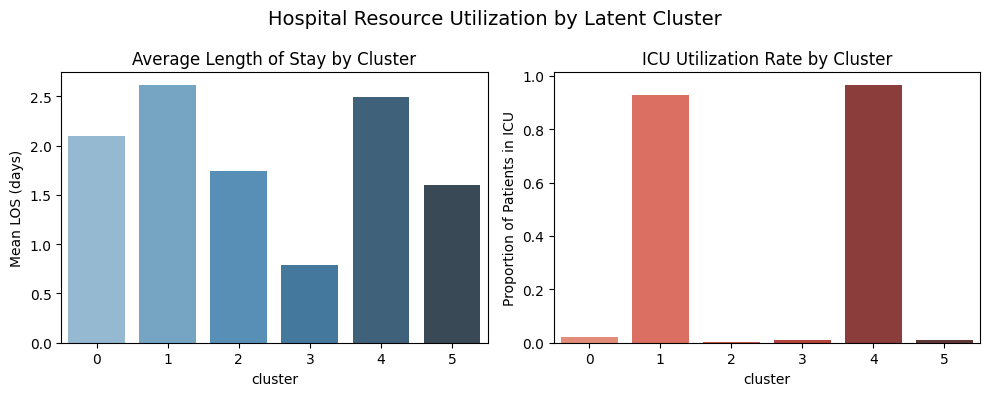

,cluster,mean_LOS,median_LOS,icu_rate,n
0,0,2.093306,2.072517,0.020649,678
1,1,2.613672,2.761525,0.927885,624
2,2,1.743632,1.636296,0.003448,580
3,3,0.791844,0.758499,0.008380,358
4,4,2.493354,2.404564,0.964968,628
5,5,1.601537,1.565283,0.012048,913


In [48]:
# === Cell 9B: hospital resource utilization by cluster ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_plot = pd.DataFrame({
    "cluster": labels,
    "ICU_rate": ICU,
    "LOS_days": LOS
})

agg = df_plot.groupby("cluster").agg(
    mean_LOS=("LOS_days", "mean"),
    median_LOS=("LOS_days", "median"),
    icu_rate=("ICU_rate", "mean"),
    n=("ICU_rate", "size")
).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.barplot(ax=axes[0], data=agg, x="cluster", y="mean_LOS", palette="Blues_d")
axes[0].set_title("Average Length of Stay by Cluster")
axes[0].set_ylabel("Mean LOS (days)")

sns.barplot(ax=axes[1], data=agg, x="cluster", y="icu_rate", palette="Reds_d")
axes[1].set_title("ICU Utilization Rate by Cluster")
axes[1].set_ylabel("Proportion of Patients in ICU")

plt.suptitle("Hospital Resource Utilization by Latent Cluster", fontsize=14)
plt.tight_layout()
plt.show()

display(agg)


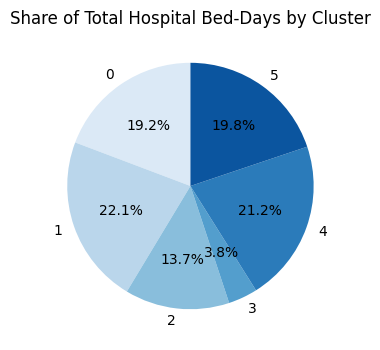

In [47]:
agg["total_bed_days"] = agg["mean_LOS"] * agg["n"]
plt.figure(figsize=(6,4))
plt.pie(agg["total_bed_days"], labels=agg["cluster"], autopct="%1.1f%%", 
        startangle=90, colors=sns.color_palette("Blues"))
plt.title("Share of Total Hospital Bed-Days by Cluster")
plt.show()
